# Blind source separation (BSS) of maternal and fetal ECG using ICA

Before you start working, please install the wfdb package. Open anaconda prompt, activate bm-336546 and type `pip install wfdb`. Do not try to install the package through the notebook. Only if you work on GoogleColab, uncomment the following cell and run it:

In [ ]:
!pip install wfdb

In [ ]:
!rm -rf ~/opt/anaconda3/lib/python3.8/site-packages/numpy


BSS is a common real-life problem. In many cases, when we measure signals, we use multiple sensors of the same type and the signals recieved at the different sensors are quite similar and not well intepretable. The signals recieved are actually a mixture of independent sources. The task is to seperate these sources from the recieved signals by some kind of reverse engineering. In our task, there are three ECG electrodes that actually recieve a mixture of the maternal ECG, the fetal ECG and noise. The way to separate those sources will be by independent component analysis (ICA). In general, ICA tries to look for a new axes system where all of the axes are statistically independent.  

In [1]:
import pickle
import wfdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.__version__

'1.23.3'

When a pregnant woman needs to have an ECG recording, the doctor places several leads on her belly. The signals recorded in each lead do not look like ECG because of two reasons: First, the location is not so close to the heart as it should be and secondly, every lead records a mixture of three signals which are the maternal ECG, the fetal ECG and noise. ICA can help us to reconstruct the signals from the leads. Let us start with showing the different leads (3 in total) which are basically the mixed signals. Every signal in the follwing figure are the "ECG" signals measured in different ECG leads.

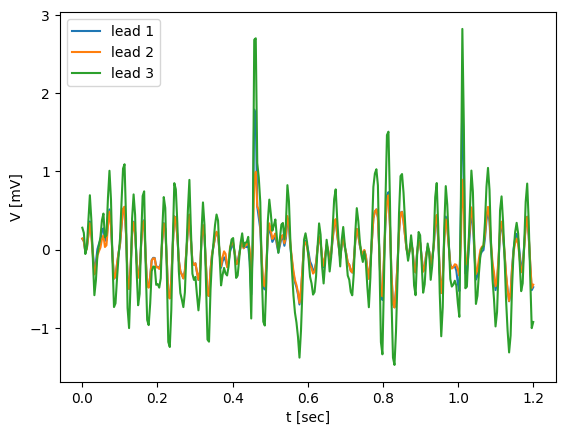

In [3]:
X = np.load('mixed_signals.npy')
Fs = 250 # [Hz]
t = np.linspace(0, X.shape[1]/Fs, X.shape[1])
plt.plot(t, X.T)
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
plt.legend(['lead 1','lead 2','lead 3'])
plt.show()

We treat every lead as a feature and every time sample within a lead as a sample.
As we can see, all the leads recorded pretty similar signals which none of them looks like an ECG. That's because every lead recorded a mixture of the maternal ECG, fetal ECG and noise as mentioned. We assume that the mixture is linear. Thus, the recieved signals above $\left(X \in R^{3X300}\right)$ can be written as $X=AS$ where $S\in R^{3X300}$ represents the source signals (one row vector is the maternal ECG, another is the fetal ECG and the noise is the remaining one). $A$ represents the linear mixture which is unknown to us. Our goal is to recover the sources, meaning find out what were the original maternal and fetal ECGs. ICA, basically tries to estimate the "demixing matrix", $W=A^{-1}$. Since, if we had this $W$, all we had to do is take the given data $X$ and simply calculate $S=WX$. We will try to estimate $W$ and then we can directly estimate the sources. We should notice that what we really calculate is $S=WX_{whiten}$. We will see that later on.

The number of independent components is the number of unknown sources. We are looking for two sources and the noise will be the third one. In our specific case, the number of sources is the number of features (3). In general, the number of features (different leads, different sensors of the same type) should be equal to the number of sources or larger in order to recover the sources.

For efficient calculations, we first whiten the data. Whitening is the process of decorrelating the features and force the variance of every feature to be 1. Let's see how it is done mathematically:

$X_{whiten}=\Lambda^{-1/2}U^T(X-\mu_x)$ where $U$'s columns are the eigen vectors of the covariance of the centered $X$, which is $(X-\mu_x)(X-\mu_x)^T$. $\Lambda$ is a diagonal matrix containing the adequate eigen values, meaning the first eigen value matches the first column in $U$ etc. Knowing that, can you explain how is the whitening process relative to a machine learning algorithm that we already saw and mention what is the ML algorithm? Think about the mean and covarince of $X_{whiten}$. Explain how does it couple with the other machine learning algorithm that you mentioned above. Write your answer in the following cell.

*Note: In diagonal matrices, the notation of $\Lambda^{-1/2}$ means the square root of the $\Lambda^{-1}$ elements. This also implies that $\Lambda^{-1/2}\Lambda^{-1/2}=\Lambda^{-1}$. Think what is the inverse matrix of a diagonal matrix.*

### Answer:

Principal Component Analysis (PCA) is a technique used in data analysis to simplify the dataset by reducing the number of variables while retaining most of the information in the data. One important feature of PCA is that it aims to decorrelate the features, meaning that it tries to remove any linear relationship between the variables in the data. This is done to make it easier to analyze the data.

In Independent Component Analysis (ICA), whitening is used to decorrelate the features, just like in PCA. Whitening refers to a process where the data is transformed to have a zero mean and unit variance, which effectively removes any correlation between the variables. The difference between PCA and ICA lies in the fact that PCA can only detect linear relationships between the features, while ICA can detect nonlinear relationships as well.

In other machine learning algorithms, such as logistic regression, standard scaling is used as a preprocessing step to decorrelate the features. Standard scaling refers to the process of scaling the data to have zero mean and unit variance. This is done to ensure that all features contribute equally to the analysis and to avoid the influence of features with larger variances dominating the analysis.

Here is the algorithm of the fast ICA:
1. Whiten $X$ (this part also includes centering $X$ first).
2. For each component $p$, find the value of $w^{(p)}$ which is the $p^{th}$ column vector of $W$.
3. Separate the sources using the $W$ you calculated.

Implement whitening process manually. Use `np.linalg.eigh` as part of the process.

In [4]:
def whitening(X):
    
    #-------------------------- IMPLEMENT THE CODE ---------------------------
    
    # Center the data
    X_centered = X - np.mean(X, axis=1, keepdims=True)
    
    # Calculate the covariance matrix of the centered data
    cov = np.cov(X_centered)
    
    # Calculate the eigen decomposition of the covariance matrix
    eigen_values, eigen_vectors = np.linalg.eigh(cov)
    
    # Construct the diagonal matrix of eigenvalues and its inverse square root
    lambda_matrix = np.diag(eigen_values)
    lambda_matrix_inv_sqrt = np.sqrt(np.linalg.inv(lambda_matrix))
    
    # Whiten the data by multiplying with the eigen decomposition
    X_whiten = lambda_matrix_inv_sqrt @ eigen_vectors.T @ X_centered
    
    
    return X_whiten

We will now look at the covariance matrix of the whitened data:

In [5]:
X_w = whitening(X)
print(np.cov(X_w))

[[ 1.00000000e+00 -7.32821459e-15 -1.18701036e-14]
 [-7.32821459e-15  1.00000000e+00  2.42243980e-15]
 [-1.18701036e-14  2.42243980e-15  1.00000000e+00]]


In [6]:
print(np.cov(X))
print(" \n VS \n ")
print(np.around(np.cov(X_w),decimals=10))

[[0.11879325 0.09793061 0.21748622]
 [0.09793061 0.08812174 0.18662739]
 [0.21748622 0.18662739 0.40587508]]
 
 VS 
 
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]


Look at the covariance matrix. Do these values match your expectations? Write your answer in the following cell.

### Answer:

The correlation matrix shows the correlation coefficients between each pair of features in the data. The values in the matrix range from -1 to 1, where 1 represents perfect positive correlation, -1 represents perfect negative correlation, and 0 represents no correlation at all . Looking at the results , all the diagonal values are close to 1, indicating that each feature is almost correlated with itself. 

The off-diagonal values are very close to 0, indicating that there is no or very weak correlation between the features. This was the main goal of the the whitning process ( to remove correlation of the data )


# ----------------------------------...---------------------------------------

We have a set of recorded signals from three leads, which represent a mixture of maternal ECG, fetal ECG, and noise.

We assume that the mixture is linear and can be represented as $X = AS$, where $S$ represents the source signals (maternal ECG, fetal ECG, and noise) and A represents the unknown linear mixing matrix. Our goal is to recover the maternal and fetal ECGs, which are the original source signals. To do this, we will use Independent Component Analysis (ICA) to estimate the demixing matrix, $W = A^-1$, which we can use to calculate the sources by taking the given data X and computing $S = WX$. However, we will actually calculate $S = W*X_{whiten}$, where $X_{whiten}$ represents the whitened data to improve the performance of ICA.

We now need to find $W \in R ^{3 x 3}$  that will allow us to reconstruct $S$ from $X_{whiten}$.

One of the most successfull algorithm is the Fixed Point ICA based on kurtosis more detailled can be find in this review (https://www.researchgate.net/publication/266589231_A_Review_of_Independent_Component_Analysis_ICA_Based_on_Kurtosis_Contrast_Function/link/551a7bb80cf2f51a6fea50ed/download)

Original paper : https://www.cs.helsinki.fi/u/ahyvarin/papers/NC97.pdf

Start with $p=0$. For each component $w^{(p)}$: 


1. Initialize $w^{(p)}$ randomly with normal distribution. For simplifying calculations, we initialized it as a random vector of the shape (3,) and not (3,1).
2. Let $w^{(p)}_n = \frac{1}{300}\sum_{i=1}^{300}[x_w^{(i)}(w^{T(p)}_{n-1}x_w^{(i)})]^3 - 3w^{(p)}_{n-1}$ 

where $x_w^{(i)}$ is $i^{th}$ column of $X_{whiten}$ and $w^{(p)}_n$ is  $w^{(p)}$ at iteration $n$.

3. $w^{(p)}_n = w^{(p)}_n- \sum_{j=0}^{p-1} (w^{T(p)}_nw^{(j)})w^{(j)}$ to decorrelate the weights. Notice that in the first case where $p=0$ then the sum will run to $p-1=-1$ which means it will not do anything and this is normal since there are no other weights so there is nothing to decorralte. If you use a for loop it should be `for j in range(p):` in order to run up to $p-1$.
4. $w^{(p)}_n = w^{(p)}_n/||w^{(p)}_n||_2$
5. If $|w^{T(p)}_nw^{(p)}_{n-1}-1| < \epsilon$ where $\epsilon=10^{-10}$ the algorithm converged for this specific p. You may store it as the $p^{th}$ column of $W$ (the 3X3 matrix that we initialized with 0) and move to the next $p$. If not, continue with the same $p$ and make another iteration, i.e. go back to step number 2 where $n=n+1$.

Implement steps (2)-(4) inclusive in `update_wp` function that takes as input arguments $w^{(p)}$ called `w_p`, the whitened data `X_w`, the current `W` and the current component $p$. It should return the updated $w^{(p)}$. This function is used in the cell that follows.

In [7]:
def update_wp(w_p, X_w, W, p):
    #---------------------Implement your code here:------------------------
    # Step 2
    w_p = (1/300)*np.sum([(np.dot(X_w[:,i], np.dot(w_p, X_w[:,i]))**3) for i in range(X_w.shape[1])]) - 3*w_p
    # Step 3
    for j in range(p):
        w_p = w_p - np.dot(np.dot(w_p, W[j]), W[j])
    # Step 4
    w_p = w_p/np.linalg.norm(w_p)
    #----------------------------------------------------------------------
    return w_p

In [8]:
from tqdm.notebook import tqdm
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

Theoretically, $W$ should end up as an orthonormal matrix. Since our reconstruction algorithm is not perfect, you should see that $W$ is almost orthonormal matrix. Show it in the next cell. In the following cell, explain your results from the previous cell by comparing what you expected to have and your results. 

In [9]:
#---------------------Implement your code here:------------------------
dot_product = W@(W.T)
print(dot_product)
print(np.around(dot_product,decimals=10))#----------------------------------------------------------------------

[[ 1.00000000e+00  1.40703049e-14  1.39500936e-13]
 [ 1.40703049e-14  1.00000000e+00 -2.25595763e-17]
 [ 1.39500936e-13 -2.25595763e-17  1.00000000e+00]]
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]


### Answer:

An orthonormal matrix is a matrix that can be expressed as:  𝑄∗𝑄𝑇=𝐼
  , in our case, we are almost getting the Identity matrix , the noise we are seeing is du to the imperfection of the reconstruction.
  
  

In [10]:
# Ground true sources for comparing later on
GT = np.load('groundtruth0.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

All we have to do now is to reconstruct the sources simply by matrix multiplication. We should note that the reconstruction is correct up to a multiplication by a constant (which can also be negative). Plot every row vector of $S$ and match it to the ground truth of maternal ECG, fetal ECG and noise. By matching, we simply mean to plot every source next to its' adequate ground true signal. You may also plot every pair at the same plot but then you should also estimate the proper constant that you should multiply your signal by. If One of your reconstructed sources needs a "flip" please mutiply by -1 even if you only plot side by side instead at the same plot. Please use the `t` for the time axis found above.

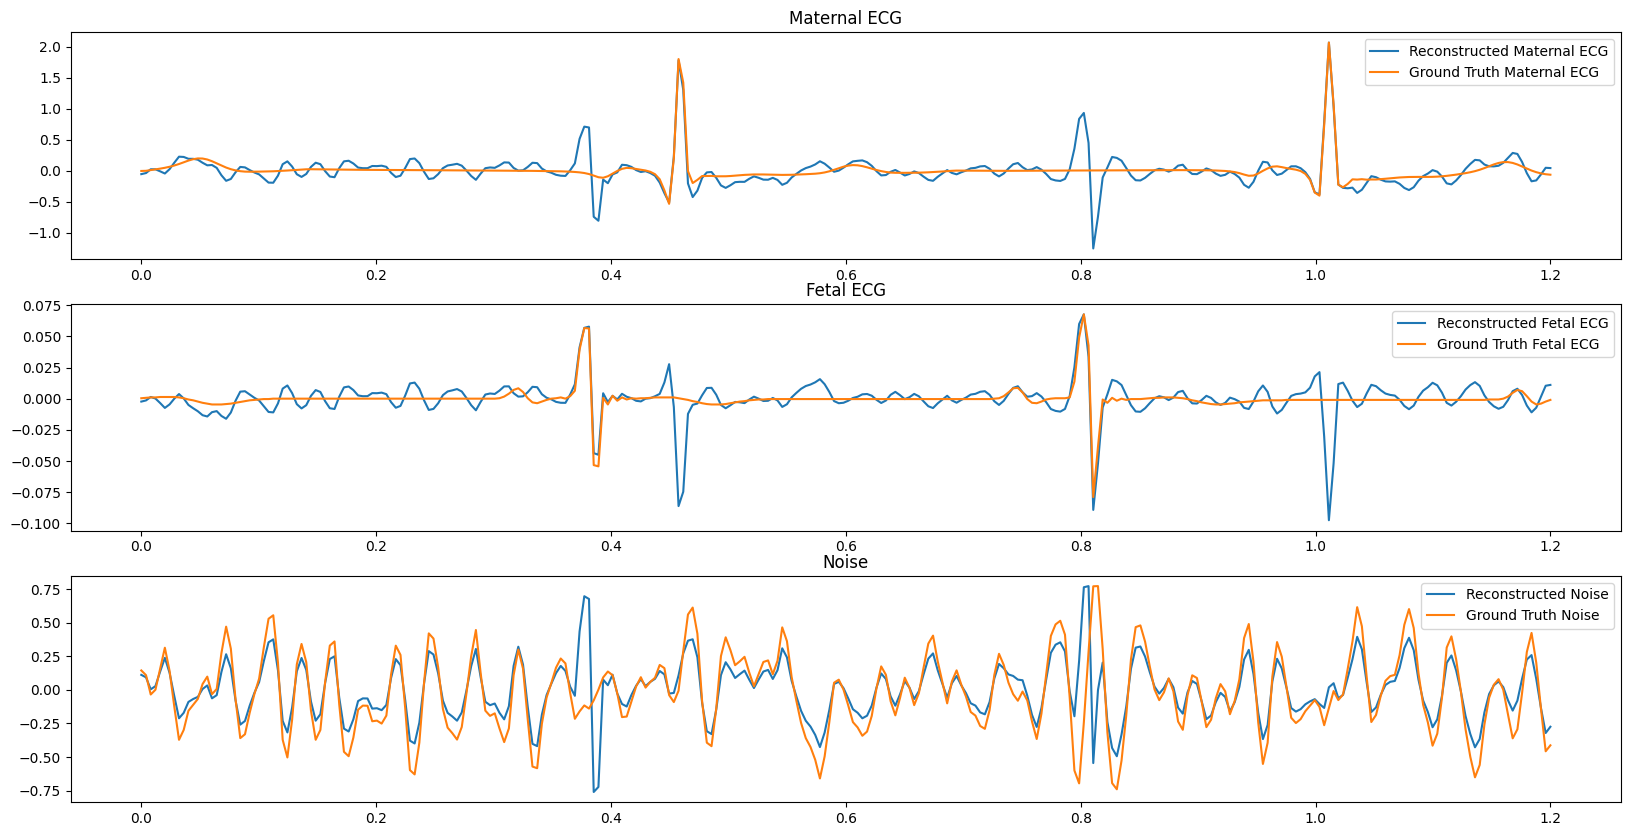

In [11]:
#---------------------Implement your code here:------------------------
# Reconstruct sources
S = np.dot(W.T, X_w)

# --- CONSTANT FOR THE GRAPH ------
S[0,:] = S[0,:]*(np.max(maternal_ecg)/np.max(S[0,:]))
S[1,:] = S[1,:]*(np.max(fetal_ecg)/np.max(S[1,:]))
S[2,:] = S[2,:]*(np.max(noise)/np.max(S[2,:]))

# ----- PLOT THE GRAPH ------
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(t, S[0,:],  label='Reconstructed Maternal ECG')
plt.plot(t, maternal_ecg,  label='Ground Truth Maternal ECG')
plt.title('Maternal ECG')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, S[1,:],  label='Reconstructed Fetal ECG')
plt.plot(t, fetal_ecg,  label='Ground Truth Fetal ECG')
plt.title('Fetal ECG')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, S[2,:],  label='Reconstructed Noise')
plt.plot(t, noise,  label='Ground Truth Noise')
plt.title('Noise')
plt.legend()
plt.show()
#----------------------------------------------------------------------


As usual, `sklearn` has its own method built in. Use `FastICA` as imported in the following cell to perform the same task. Notice carefully for the dimensions of the data $X$ that it expects to operate on. Check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

In [12]:
from sklearn.decomposition import FastICA
#---------------------Implement your code here:------------------------
np.random.seed(42)
W = np.zeros((3,3))
ICA = FastICA(n_components=3, max_iter=max_iter, tol=threshold, w_init=W)
ICA.fit(X)
ICA_trans = ICA.fit_transform(X)
S_ICA = ICA.inverse_transform(ICA_trans)
#----------------------------------------------------------------------

/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


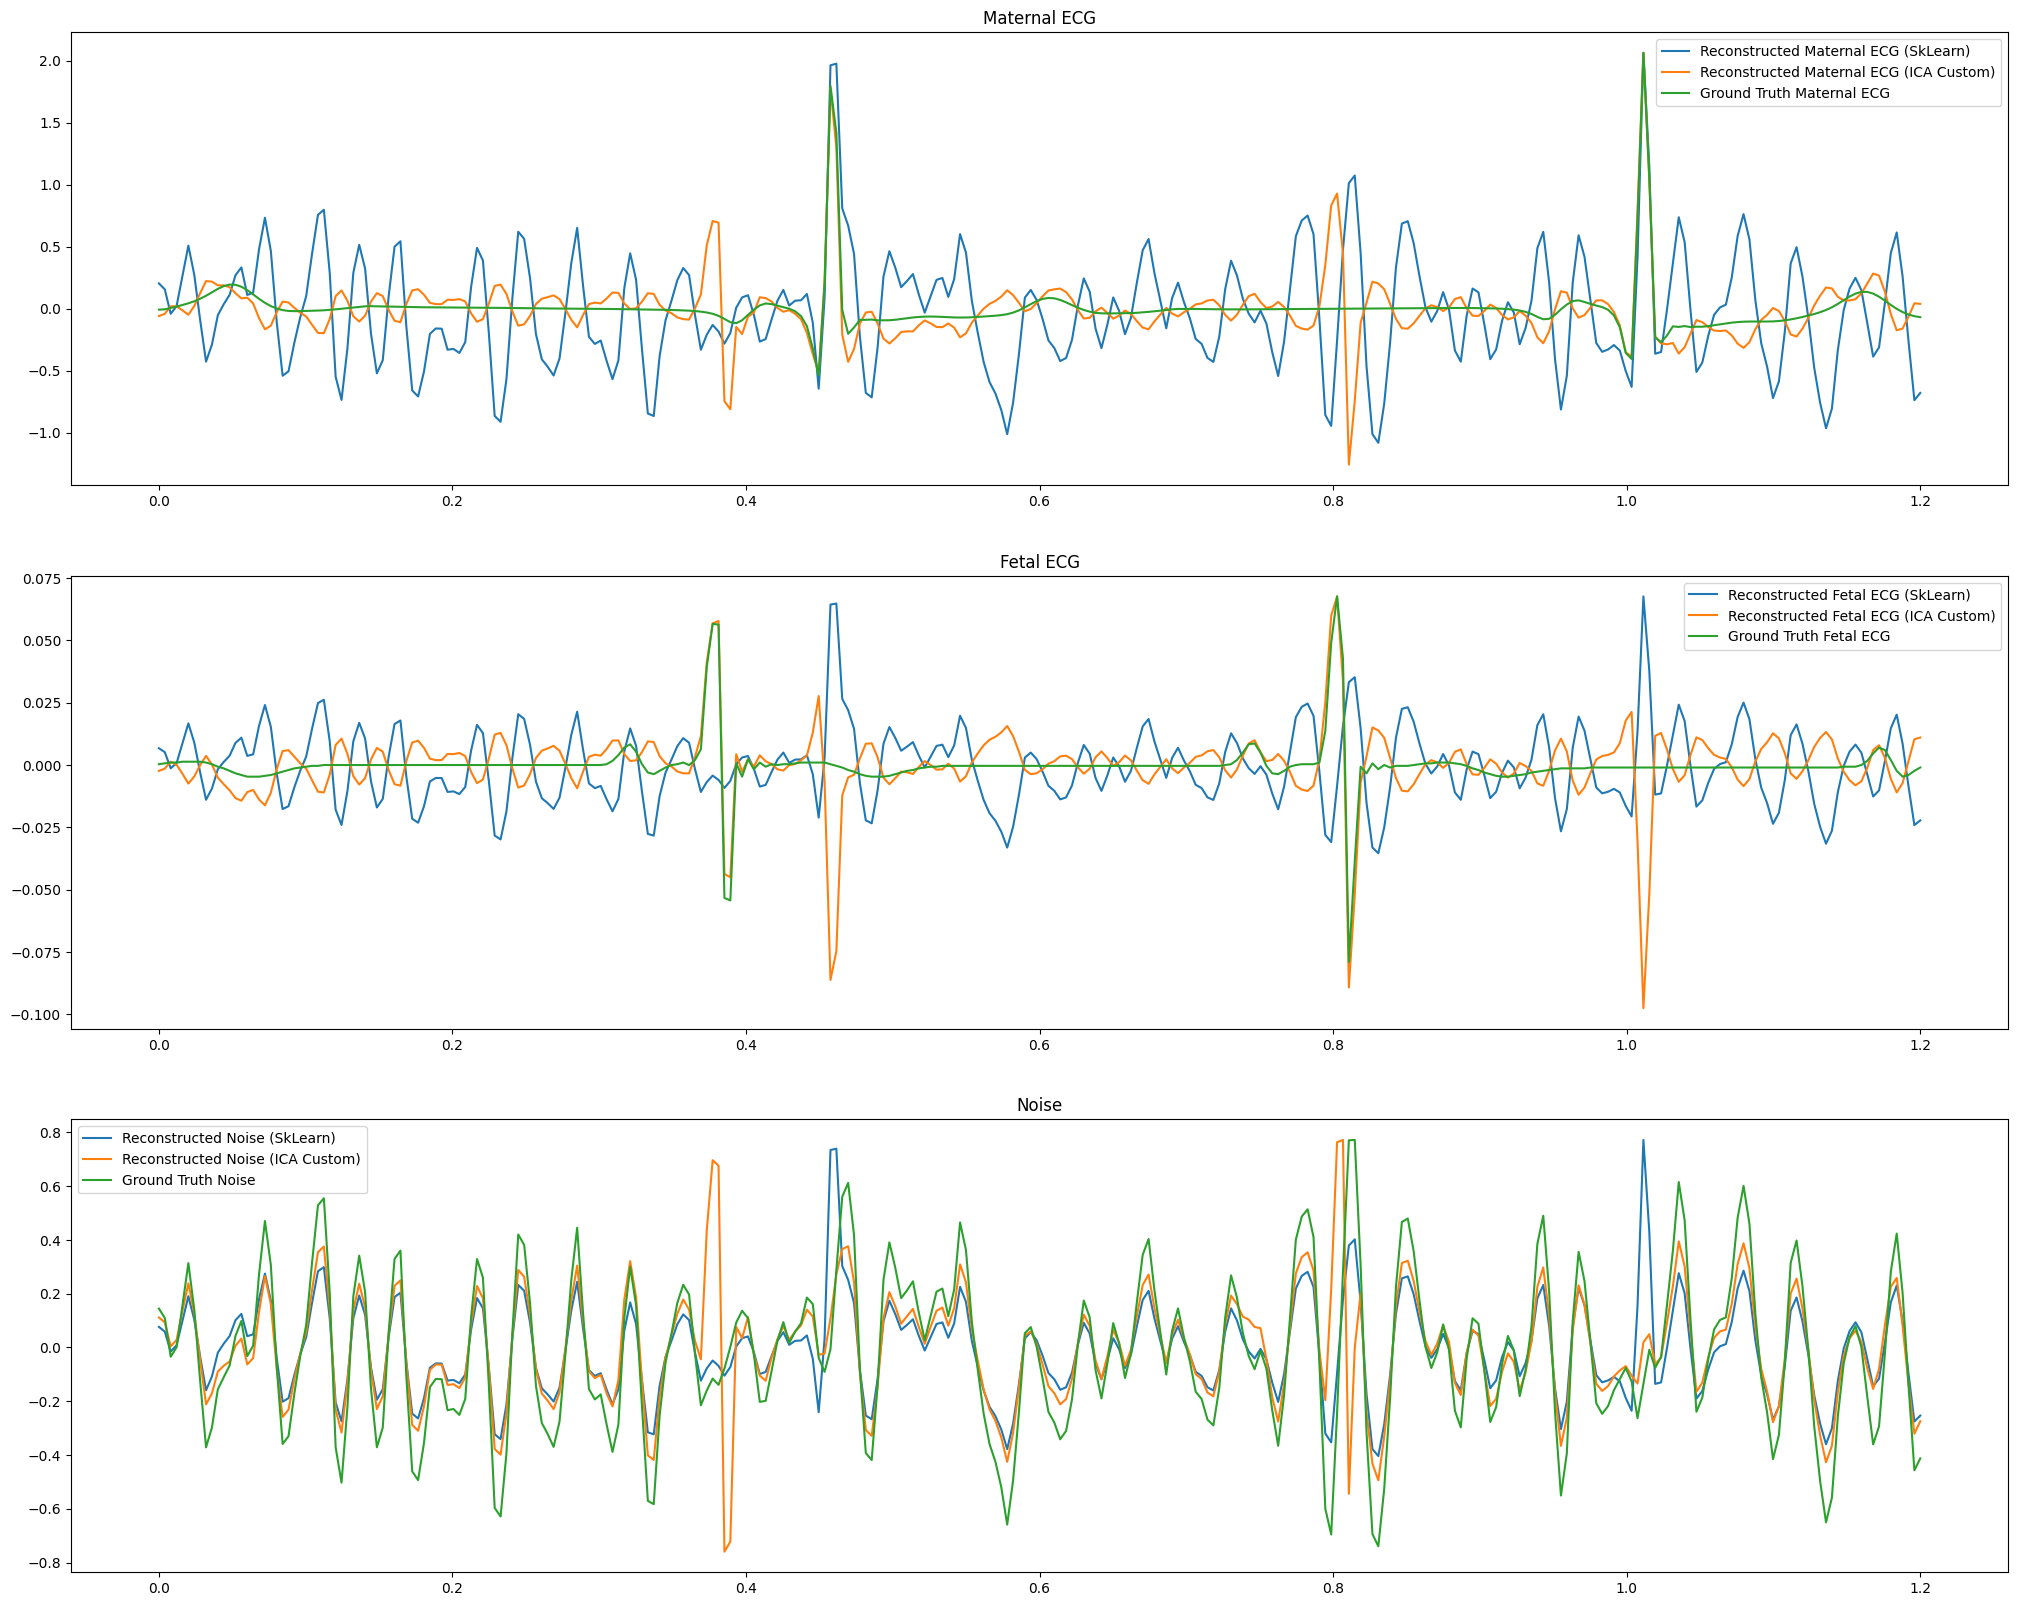

In [13]:
#---------------------Implement your code here:------------------------

# ---------- CONSTANT FOR THE GRAPH ---------- 

S[0,:] = S[0,:]*(np.max(maternal_ecg)/np.max(S[0,:])) 
S[1,:] = S[1,:]*(np.max(fetal_ecg)/np.max(S[1,:]))
S[2,:] = S[2,:]*(np.max(noise)/np.max(S[2,:]))

S_ICA[0,:] = S_ICA[0,:]*(np.max(maternal_ecg)/np.max(S_ICA[0,:])) # Mutiply by -1 
S_ICA[1,:] = S_ICA[1,:]*(np.max(fetal_ecg)/np.max(S_ICA[1,:]))
S_ICA[2,:] = S_ICA[2,:]*(np.max(noise)/np.max(S_ICA[2,:]))

# ------------ PLOT THE GRAPH -----------------------

fig=plt.figure(figsize=(25,20))

plt.subplot(3,1,1)
plt.plot(t, S_ICA[0,:],  label='Reconstructed Maternal ECG (SkLearn)')
plt.plot(t, S[0,:],  label='Reconstructed Maternal ECG (ICA Custom)')
plt.plot(t, maternal_ecg,  label='Ground Truth Maternal ECG')
plt.title('Maternal ECG')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, S_ICA[1,:],  label='Reconstructed Fetal ECG (SkLearn)')
plt.plot(t, S[1,:],  label='Reconstructed Fetal ECG (ICA Custom)')
plt.plot(t, fetal_ecg,  label='Ground Truth Fetal ECG')
plt.title('Fetal ECG')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, S_ICA[2,:],  label='Reconstructed Noise (SkLearn)')
plt.plot(t, S[2,:],  label='Reconstructed Noise (ICA Custom)')
plt.plot(t, noise,  label='Ground Truth Noise')
plt.title('Noise')
plt.legend()
plt.show()

#----------------------------------------------------------------------

Now we will take the same measurements but with higer SNR (signal to noise ratio):

In [14]:
X_clean = np.load('mixed_signal12.npy')
X_clean.shape

(3, 300)

We will run again the ICA.

In [15]:
X_w = whitening(X_clean)
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

These are the ground true measurements:

In [16]:
GT = np.load('groundtruth12.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

Compare the results agian with the given ground true measurements given in the cell above. 

/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/raphaelbellahsen/.local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


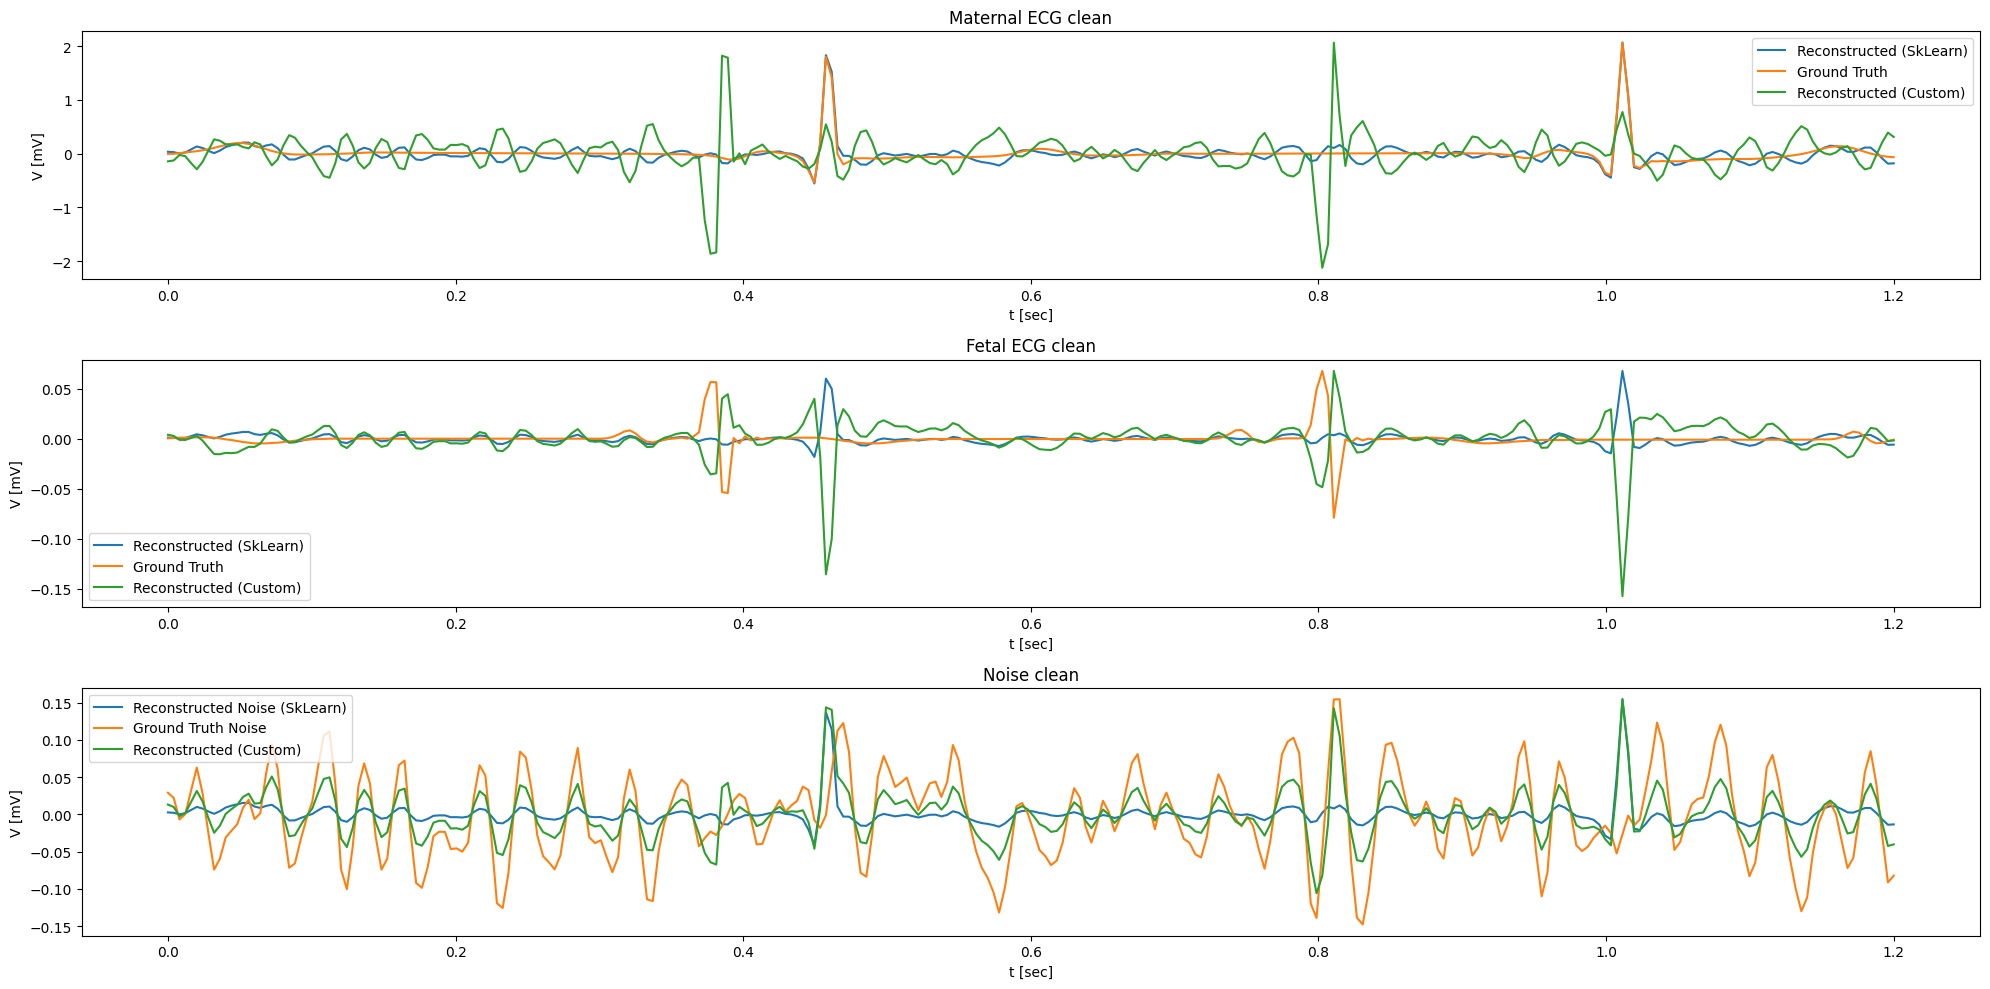

In [17]:
#---------------------Implement your code here:------------------------

#---- ICA --------------
S = np.dot(W.T, X_w)

W = np.zeros((3,3))
w_p = np.random.randn(n_component)
ICA = FastICA(n_components=n_component, max_iter=max_iter, tol=threshold, w_init=W)
ICA.fit(X_clean)
ICA_trans = ICA.fit_transform(X_clean)
S_ICA_SNR = ICA.inverse_transform(ICA_trans)


S[0,:] = S[0,:]*(np.max(maternal_ecg)/np.max(S[0,:]))
S[1,:] = S[1,:]*(np.max(fetal_ecg)/np.max(S[1,:]))
S[2,:] = S[2,:]*(np.max(noise)/np.max(S[2,:]))


S_ICA_SNR[0,:] = S_ICA_SNR[0,:]*(np.max(maternal_ecg)/np.max(S_ICA_SNR[0,:]))
S_ICA_SNR[1,:] = S_ICA_SNR[1,:]*(np.max(fetal_ecg)/np.max(S_ICA_SNR[1,:]))
S_ICA_SNR[2,:] = S_ICA_SNR[2,:]*(np.max(noise)/np.max(S_ICA_SNR[2,:]))

fig=plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(t, S_ICA_SNR[0,:],  label='Reconstructed (SkLearn)')
plt.plot(t, maternal_ecg,  label='Ground Truth')
plt.plot(t, S[0,:],  label='Reconstructed (Custom)')
plt.title('Maternal ECG clean')
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
fig.tight_layout()
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, S_ICA_SNR[1,:],  label='Reconstructed (SkLearn)')
plt.plot(t, fetal_ecg,  label='Ground Truth ')
plt.plot(t, S[1,:],  label='Reconstructed (Custom)')
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
fig.tight_layout()
plt.title('Fetal ECG clean')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, S_ICA_SNR[2,:],  label='Reconstructed Noise (SkLearn)')
plt.plot(t, noise,  label='Ground Truth Noise')
plt.plot(t, S[2,:],  label='Reconstructed (Custom)')
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
fig.tight_layout()
plt.title('Noise clean')
plt.legend()
plt.show()
#----------------------------------------------------------------------

Did you expect better recontructio with higher SNR. If it did not happen, what could possibly explain it?

## Answer:

SNR stands for Signal-to-Noise Ratio, which is a measure of the strength of a signal relative to the background noise that interferes with the signal. It is the ratio of the power of the signal to the power of the noise. A higher SNR means that the signal is stronger relative to the noise, which results in a clearer and more reliable signal. A lower SNR means that the signal is weaker and may be more difficult to detect or analyze due to the presence of noise.

When we have a high SNR, it means that the signal we are trying to analyze is clearer and has less background noise. So, we expect to get better results when using a technique called ICA to find the important parts of the signal. However, if the relationship between the parts of the signal is linear, then ICA may not work better with higher SNR ( Maybe trying with PCA will give better result )

GOOD LUCK!